# ◆[Kickstarter Projects](https://www.kaggle.com/kemical/kickstarter-projects)
### 目的：クラウドファンディングが成功するかを事前に予測する
- Create Date：2020/01/30　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

#### 【手順】
0. [**Notebook内で利用する関数の定義**](#import_module)
1. [**データ読込**](#import_data)
2. [**特徴抽出**](#feature_extraction)
3. [**データ前処理**](#prepearing)
4. [**特徴選択**](#selection)
5. [**モデル構築**](#modeling)
6. [**モデル評価**](#result)

##### ※「ks-projects-201801.csv」（データ数：378,661行15列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | ID| 識別ID | - | 予測に不要と考えられる為、除外 |
|  2 | name |名称 | 欠損あり | ○※文字数,単語数,最終文字を利用 |
|  3 | category |カテゴリ | - | ○ |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日 | - | ○※期間算出,月,日を算出 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使う為、除外 |
|  8 | launched |開始日時 | - | ○※期間算出,月,日,時間を抽出 |
|  9 | pledged |集まった資金 | - | 予測時に利用できない為、除外 |
| 10 | state |プロジェクトの状態 | - | ◎※目的変数で利用（成功と失敗のみ抽出） |
| 11 | backers |支援者数 | - | 予測時に利用できない為、除外 |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | 予測時に利用できない為、除外 |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | 予測時に利用できない為、除外 |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |

## 0.Notebook内で利用する関数の定義<a id='import_module'></a>

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
import xgboost as xgb
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats             import randint as sp_randint
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from xgboost.sklearn         import XGBClassifier
from sklearn.ensemble        import VotingClassifier
from sklearn.tree            import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection             import RFECV
from tensorflow.compat.v1.keras            import Sequential
from tensorflow.compat.v1.keras.layers     import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras                                 import optimizers
from keras.wrappers.scikit_learn           import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

start_notebook = time()

# ****************************************************************************
# 設定値
# ****************************************************************************

# ▼件数絞込用（時間がかかりすぎるため）
squeeze_num0 = 30000
squeeze_num = 20000 # ※1以上の場合有効

decorr_flg = False # 無相関化するか
wrapper_flg = False # ラッパー法（ステップワイズ法）実施するか

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)

# ============================================================================
# 結果をテキストファイルへ出力
# ============================================================================
def f_write(string):
    f = open('./result.txt', 'a') #追記
    dt_now = datetime.datetime.now()
    f.write('\n'+ dt_now.strftime('%Y/%m/%d %H:%M:%S') + '： ' + string) 
    f.close()
    
# ============================================================================
# 関数：成功と失敗別のヒストグラムと歪度
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram(col_name,w,h,bins_val):
    print('\n▼ ' + str(col_name) + 'の分布 ※歪度：' + str(df[col_name].skew()))
    plt.figure(figsize=(w,h))
    sns.distplot(df[df['state']==0][col_name],kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(df[df['state']==1][col_name],kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：対数変換した成功と失敗別のヒストグラム
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram_log1p(col_name,w,h,bins_val):
    print('\n▼ 対数変換した' + str(col_name) + 'の分布')
    plt.figure(figsize=(w,h))
    sns.distplot(np.log1p(df[df['state']==0][col_name]),kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(np.log1p(df[df['state']==1][col_name]),kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name)
    plt.legend()
    plt.show()
    
# ============================================================================
# 関数：成功と失敗別に散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_scatter_plot(col_name, w, h):
    print('\n▼ ' + str(col_name) + 'の散布図')
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1.index, data1[col_name], 'o', color='C1', label='successful')
    plt.plot(data2.index, data2[col_name], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.ylabel(col_name)
    plt.xlabel('row_index')
    plt.show()
    
# ============================================================================
# 関数：2項目の相関関係と成功失敗を色分けして散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_corr_scatter_plot(col_name1, col_name2, w, h):
    print('\n▼ ' + str(col_name1) + ' と ' + str(col_name2) + ' の相関 ※相関係数: {:.3f}'.format(
    np.corrcoef(df[col_name1].values,df[col_name2].values)[0,1]))
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1[col_name1], data1[col_name2], 'o', color='C1', label='successful')
    plt.plot(data2[col_name1], data2[col_name2], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name1) + ' and ' + str(col_name2))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name1)
    plt.ylabel(col_name2)
    plt.show()

# ============================================================================
# 関数：成功数と失敗数別にカウント表示するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート有無、xラベルの回転
# ============================================================================
def show_state_count_plot(col_name, w, h, sort_flg=False, x_rot = 0):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数（降順）')
        ax = sns.countplot(df[col_name],hue=df['state'],order = df[col_name].value_counts().index)
    else:
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数')
        ax = sns.countplot(df[col_name],hue=df['state'])
        
    ax.set_title('Count by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Count')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：成功率を棒グラフで比較するグラフ
# 引数：データ名,グラフの横幅、縦幅、平均値、降順ソート有無、xラベルの回転
# ============================================================================
def show_successrate_barplot(col_name, w, h, baseline, sort_flg=False, x_rot = 0):
    # stateの平均値が成功率になる（成功率＝成功の件数/全体の件数）
    successrate = pd.DataFrame(df['state'].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values('state', ascending=False) # 成功率の降順
        print('\n▼ ' + str(col_name) + '別の成功率（降順）※赤線：学習データの平均成功率')
    else:
        print('\n▼ ' + str(col_name) + '別の成功率 ※赤線：学習データの平均成功率')
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="state", data=successrate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title('Success rate by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Ratio')
    plt.show()

# ============================================================================
# 学習曲線を作成
# モデル、タイトル、X,y
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    #print('\ntrain_sizes=\n',train_sizes)
    #print('\ntrain_scores_mean=\n',train_scores_mean)
    #print('\ntrain_scores_std=\n',train_scores_std)
    #print('\ntest_scores_mean=\n',test_scores_mean)
    #print('\ntest_scores_std=\n',test_scores_std)
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()


C:\Users\arsma\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\arsma\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\arsma\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\arsma\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# 1.データ読込<a id='import_data'><a>

In [2]:
f_write('\n-------------------------------------------------------------------')
f_write('▼処理開始')

df= pd.read_csv('./ks-projects-201801.csv',parse_dates=['deadline', 'launched'])

# 計算時間を考慮してデータ絞込
if squeeze_num0 > 0:
    df = df[0:squeeze_num0]

print('\n▼ 先頭3行表示')
display(df.head(3))

print('\n▼ 基本統計量')
display(df.describe())

print('\n▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))


▼ 先頭3行表示


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00



▼ 基本統計量


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,2.969600e+04,3.000000e+04,3.000000e+04
mean,9.791409e+08,3.967860e+04,9.828837e+03,104.254400,6.904314e+03,9.216117e+03,3.421124e+04
std,2.955287e+08,7.434519e+05,9.450662e+04,899.311683,7.546540e+04,9.163113e+04,6.611849e+05
min,1.061440e+05,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,7.500000e-01
25%,1.025734e+09,2.000000e+03,3.400000e+01,2.000000,2.000000e+01,3.417000e+01,2.000000e+03
50%,1.067177e+09,5.000000e+03,6.355850e+02,12.000000,4.093450e+02,6.365000e+02,5.250000e+03
75%,1.109913e+09,1.600000e+04,4.110000e+03,56.000000,3.090000e+03,4.064423e+03,1.533173e+04
max,1.152501e+09,1.000000e+08,8.596475e+06,85581.000000,8.596475e+06,8.596475e+06,1.000000e+08



▼ 欠損データ確認


,Missing num
usd pledged,304


# 2.特徴抽出<a id='feature_extraction'></a>
## 2-1.説明変数の選定


▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化


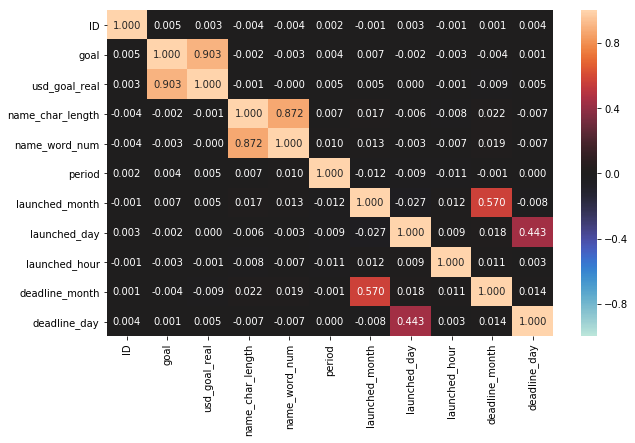

→フィルタ法にてgoalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。
→name_word_numとname_char_lengthは、正の相関があるので無相関化を検討する。


In [3]:
# 予測時に利用できない項目を削除
df = df.drop(['backers'], axis=1)          # 集客数は予測時に利用できない為、除外
df = df.drop(['pledged'], axis=1)          # 集まった資金は予測時に利用できない為、除外
df = df.drop(['usd pledged'], axis=1)      # 欠損があり、集まった資金は予測時に利用できない為、除外
df = df.drop(['usd_pledged_real'], axis=1) # 集まった資金は予測時に利用できない為、除外

# 説明変数になりそうな項目を追加
df['name_char_length'] = df['name'].apply(lambda x: len(str(x).replace(' ', ''))) # nameの文字数
df['name_word_num'] = df['name'].apply(lambda x: len(str(x).split(' ')))          # nameの単語数   ・・・追加
df['name_end_char'] = df['name'].apply(lambda x: str(x).replace(' ', '')[-1])     # nameの最終文字 ・・・追加
df['period'] = (df['deadline'] - df['launched']).dt.days  # 開始日時と終了日から期間を算出
df['launched_month'] = df['launched'].dt.month            # 開始時期の月に着目
df['launched_day'] = df['launched'].dt.day                # 開始時期の日に着目
df['launched_hour'] = df['launched'].dt.hour              # 開始時期の時間に着目
df['deadline_month'] = df['deadline'].dt.month            # 終了時期の月に着目・・・追加
df['deadline_day'] = df['deadline'].dt.day                # 終了時期の日に着目・・・追加

# ヒートマップ
print('\n▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.show()
print('→フィルタ法にてgoalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。')
print('→name_word_numとname_char_lengthは、正の相関があるので無相関化を検討する。')

# 説明変数にはならなそうな項目を除外
df = df.drop(['ID'], axis=1)               # 不要と考え除外
df = df.drop(['name'], axis=1)             # 欠損があり、説明変数にするには難しいと思われるので除外
df = df.drop(['goal'], axis=1)             # usd_goal_realとほぼ等しい為、除外

# 抽出元の不要な項目を削除
df = df.drop(['launched'], axis=1)
df = df.drop(['deadline'], axis=1)

## 2-2.目的変数の確認


▼ 目的変数 stateの種類（%）


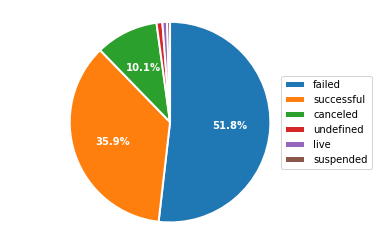

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。

▼ stateが成功または失敗のデータを抽出


,state
failed,15547
successful,10773



▼ 成功率の平均値
baseline= 0.4093085106382979


In [4]:
print('\n▼ 目的変数 stateの種類（%）')
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print('→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。')

# stateが成功または失敗のデータを抽出
df = df.query('state in ["successful", "failed"]')

print('\n▼ stateが成功または失敗のデータを抽出')
display(pd.DataFrame(df['state'].value_counts(),columns=['state']))

# 変換（成功=1，失敗=0）
df['state'] = df['state'].map({'failed': 0,'successful': 1})

# 成功率の平均
print('\n▼ 成功率の平均値')
baseline = df['state'].mean()
print('baseline=',baseline)


## 2-3.各説明変数と目的変数の関係を確認
### 2-3-1.期間（period）


▼ periodの分布 ※歪度：1.236562724470492


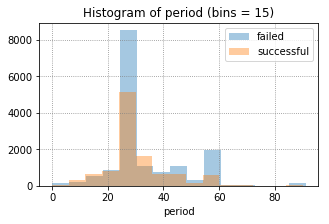

→失敗よりも成功が多い期間がある。

▼ period別の成功数と失敗数


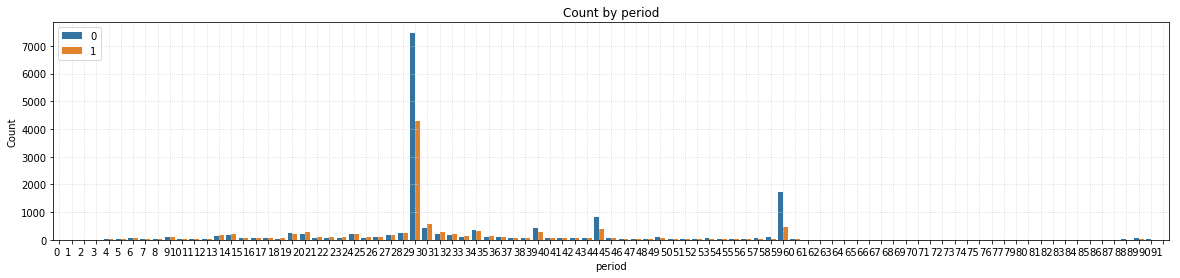

→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。

▼ period別の成功率 ※赤線：学習データの平均成功率


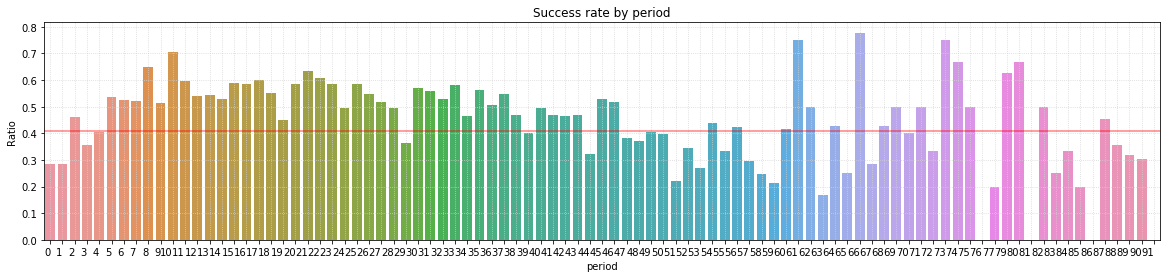

→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。


In [5]:
show_histogram('period',5,3,15)
print('→失敗よりも成功が多い期間がある。')

# 期間(日数)の分布を確認
show_state_count_plot('period',20,4)
print('→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。')

# 期間(日数)別の成功率を確認
show_successrate_barplot("period",20,4,baseline,False)
print('→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。')

### 2-3-2. 目標金額（usd_goal_real）


▼ usd_goal_realの散布図


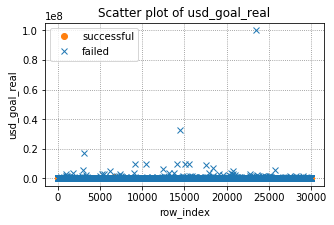

→目標金額が高すぎるものは、失敗している。

▼ usd_goal_realの分布 ※歪度：121.44101663081776


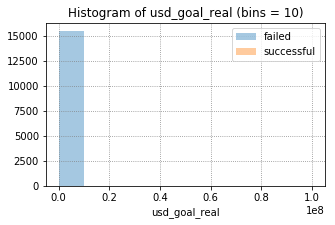

→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する

▼ 対数変換したusd_goal_realの分布


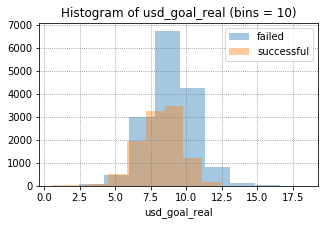

→全体的に目標金額が高くなると失敗しやすくなりそう。


In [6]:
# 外れ値がないか散布図で確認
show_scatter_plot('usd_goal_real',5,3)
print('→目標金額が高すぎるものは、失敗している。')
# 目標金額の分布
show_histogram('usd_goal_real',5,3,10)
print('→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する')
show_histogram_log1p('usd_goal_real',5,3,10)
print('→全体的に目標金額が高くなると失敗しやすくなりそう。')

### 2-3-3. 開始時期（launched_month、launched_day、launched_hour）


▼ launched_month別の成功数と失敗数


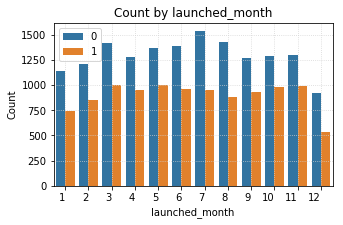


▼ launched_month別の成功率 ※赤線：学習データの平均成功率


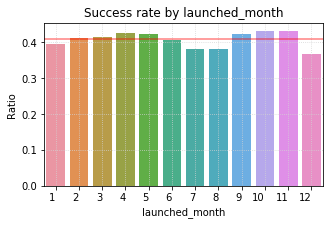

→春と秋あたりに開始すると成功率が若干高まる。

▼ launched_day別の成功数と失敗数


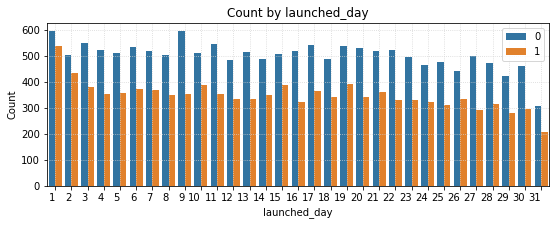


▼ launched_day別の成功率 ※赤線：学習データの平均成功率


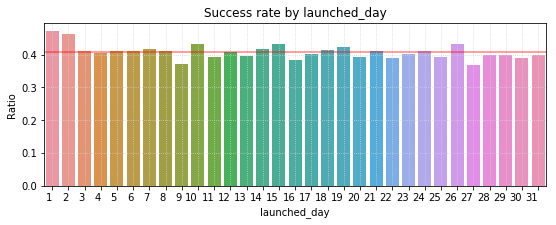

→月の上旬（特に1日開始）の成功率が若干高い。

▼ launched_hour別の成功数と失敗数


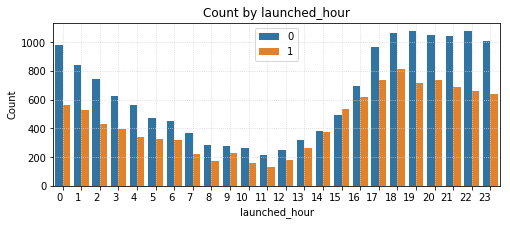


▼ launched_hour別の成功率 ※赤線：学習データの平均成功率


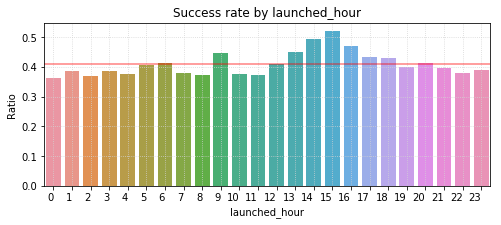

→午後2,3時あたりに開始すると成功率が高まるようだ。


In [7]:
show_state_count_plot('launched_month',5,3)
show_successrate_barplot('launched_month',5,3,baseline)
print('→春と秋あたりに開始すると成功率が若干高まる。')

show_state_count_plot('launched_day',9,3)
show_successrate_barplot("launched_day",9,3,baseline)
print('→月の上旬（特に1日開始）の成功率が若干高い。')

show_state_count_plot('launched_hour',8,3)
show_successrate_barplot("launched_hour",8,3,baseline)
print('→午後2,3時あたりに開始すると成功率が高まるようだ。')

### 2-3-4. 終了時期（deadline_month、deadline_day）


▼ deadline_month別の成功数と失敗数


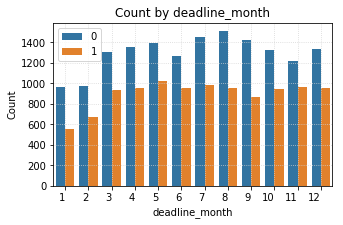


▼ deadline_month別の成功率 ※赤線：学習データの平均成功率


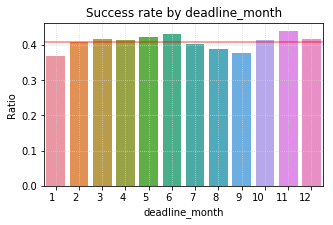


▼ deadline_day別の成功数と失敗数


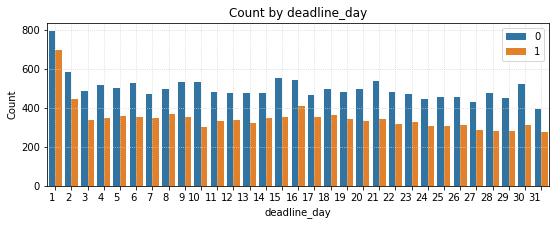


▼ deadline_day別の成功率 ※赤線：学習データの平均成功率


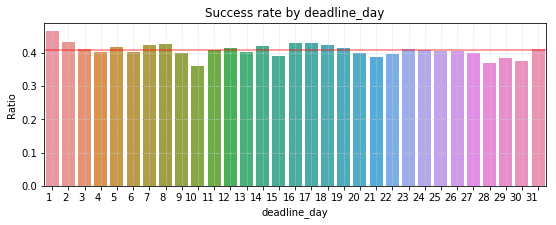

In [8]:
show_state_count_plot('deadline_month',5,3)
show_successrate_barplot('deadline_month',5,3,baseline)

show_state_count_plot('deadline_day',9,3)
show_successrate_barplot("deadline_day",9,3,baseline)

### 2-3-5. 主なカテゴリとカテゴリ（main_category、category）


▼ main_categoryとcategory別のカウントと成功率


state          
                                count      mean
main_category category                         
Art           Art                 598  0.468227
              Ceramics             29  0.413793
              Conceptual Art       80  0.450000
              Digital Art          93  0.344086
              Illustration        250  0.564000
              Installations        34  0.441176
              Mixed Media         189  0.375661
              Painting            228  0.307018
              Performance Art     156  0.519231
              Public Art          242  0.553719
              Sculpture           144  0.381944
              Textiles             12  0.333333
              Video Art            16  0.375000
Comics        Anthologies          29  0.827586
              Comic Books         195  0.707692
...                               ...       ...
Technology    Robots               39  0.461538
              Software            208  0.182692
              Sound                34  0.470588
              Space Exploration    19  0.473684
              Technology          452  0.276549
              Wearables            84  0.369048
              Web                 259  0.084942
Theater       Comedy                8  0.625000
              Experimental         28  0.678571
              Festivals            47  0.659574
              Immersive            24  0.416667
              Musical              64  0.484375
              Plays               111  0.675676
              Spaces               19  0.526316
              Theater             534  0.655431

[169 rows x 2 columns]

→main_categoryとcategoryは別々で考慮したほうが良さそう。

▼ main_category別の成功数と失敗数（降順）


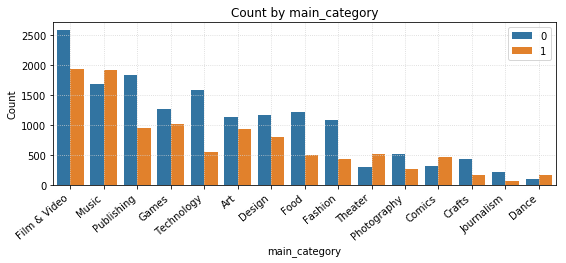


▼ main_category別の成功率（降順）※赤線：学習データの平均成功率


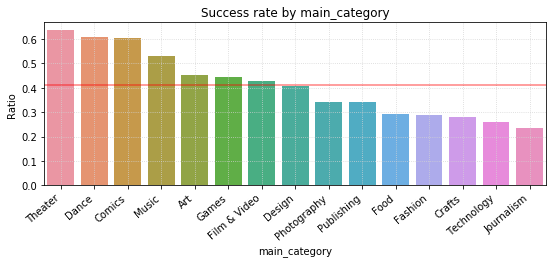

→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。

▼ category別の成功数と失敗数（降順）


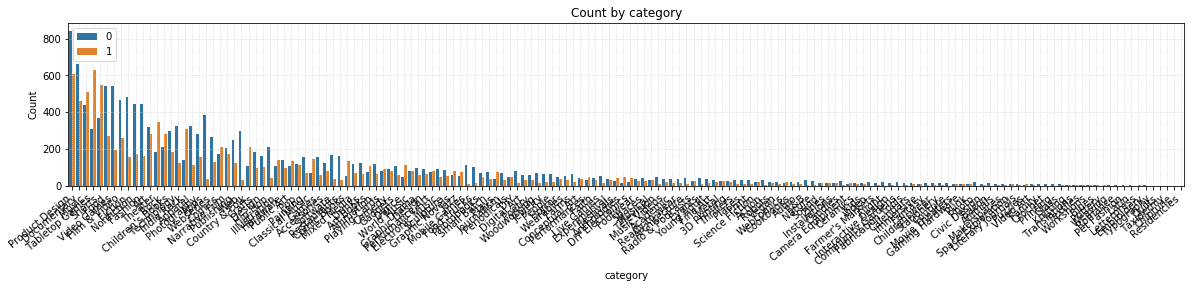


▼ category件数順（Top10）


,category
Product Design,1447
Documentary,1121
Music,951
Tabletop Games,939
Shorts,918
Food,814
Video Games,734
Film & Video,730
Fiction,637
Nonfiction,616



▼ category別の成功率（降順）※赤線：学習データの平均成功率


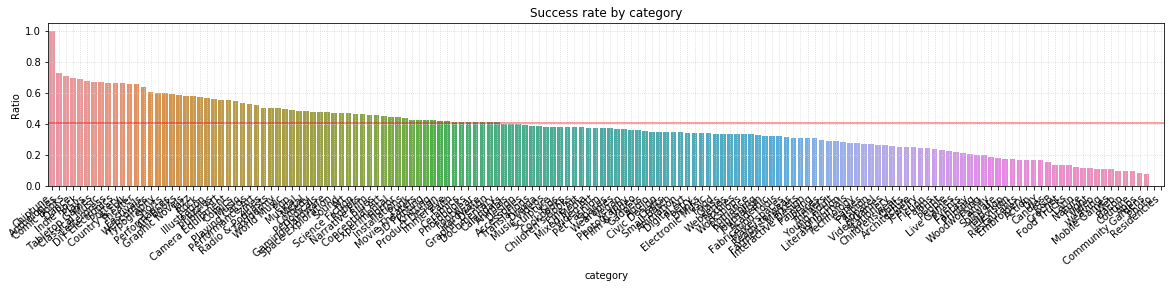


▼ category成功率順（Top10）


,state
category,
Chiptune,1.000000
Anthologies,0.728571
Comic Books,0.707692
Dance,0.694611
Indie Rock,0.689038
Plays,0.675676
Tabletop Games,0.671991
Classical Music,0.669683
Letterpress,0.666667


→成功しやすいcategoryと失敗しやすいcategoryがありそう。


In [9]:
# main_categoryとcategoryの関係
print('\n▼ main_categoryとcategory別のカウントと成功率')
df_category = df[['main_category','category','state']]

display(df_category.groupby(['main_category', 'category']).agg(['count','mean']))
print('→main_categoryとcategoryは別々で考慮したほうが良さそう。')

# main_category
show_state_count_plot('main_category',9,3, True,40)
show_successrate_barplot('main_category',9,3, baseline,True,40)
print('→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。')

# category
show_state_count_plot('category',20,3, True,40)

print('\n▼ category件数順（Top10）')
display(pd.DataFrame(df['category'].value_counts(),columns=['category']).head(10))

show_successrate_barplot('category',20,3, baseline,True,40)

print('\n▼ category成功率順（Top10）')
successrate = pd.DataFrame(df['state'].groupby(df['category']).mean())
successrate_s = successrate.sort_values('state', ascending=False) # 成功率降順
display(successrate_s.head(10))

print('→成功しやすいcategoryと失敗しやすいcategoryがありそう。')


### 2-3-6. 通貨と開催国（currency、country）


▼ currencyとcountry別のカウントと成功率


state          
                  count      mean
currency country                 
AUD      AU         513  0.296296
CAD      CA         981  0.348624
         N,0"         2  0.500000
CHF      CH          47  0.255319
DKK      DK          64  0.281250
EUR      AT          43  0.255814
         BE          52  0.269231
         DE         259  0.285714
         ES         145  0.296552
         FR         213  0.300469
         IE          57  0.368421
         IT         227  0.171806
         LU           7  0.428571
         NL         178  0.241573
GBP      GB        2349  0.415496
         N,0"         3  0.333333
HKD      HK          43  0.511628
JPY      JP           1  0.000000
MXN      MX         122  0.262295
NOK      NO          56  0.250000
NZD      NZ          85  0.294118
SEK      SE         124  0.233871
SGD      SG          37  0.378378
USD      N,0"        16  0.625000
         US       20696  0.425831

→country=N,0"について、除外する

▼ currency別の成功数と失敗数（降順）


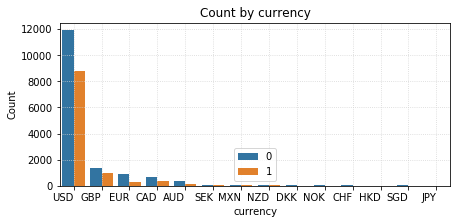


▼ currency別の成功率（降順）※赤線：学習データの平均成功率


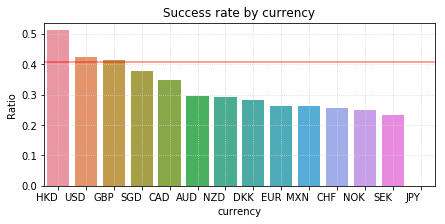


▼ country別の成功数と失敗数（降順）


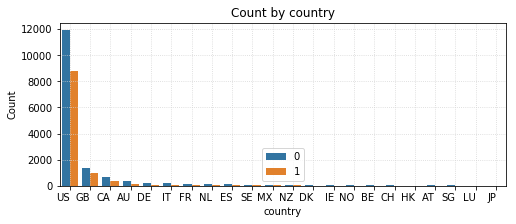


▼ country別の成功率（降順）※赤線：学習データの平均成功率


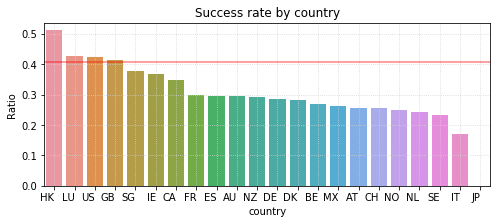

→currencyとcountryは関連しているので、どちらか一方でよいかも。


In [10]:
# currencyとcountryの関係を確認
print('\n▼ currencyとcountry別のカウントと成功率')

df_currency = df[['currency','country','state']]
display(df_currency.groupby(['currency','country']).agg(['count','mean']))

print('→country=N,0\"について、除外する')
df = df[(df['country'] != 'N,0"')]

# currency
show_state_count_plot('currency',7,3,True)
show_successrate_barplot('currency',7,3,baseline,True)

# country
show_state_count_plot('country',8,3,True)
show_successrate_barplot('country',8,3,baseline,True)

print('→currencyとcountryは関連しているので、どちらか一方でよいかも。')

### 2-3-7. 名称の文字数と単語数、最終文字（name_char_length／name_word_num／name_end_char）


▼ 最終文字の種類
Other    23012
!         2111
.         1049
?          127
Name: name_end_char, dtype: int64
→nameの最終文字を「!」と「?」と「.」とそれ以外「Other」に分割して比較する。

▼ name_end_char別の成功数と失敗数


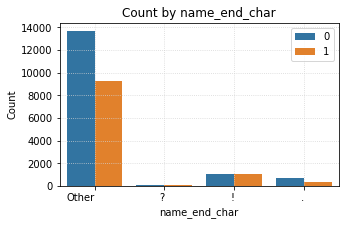


▼ name_end_char別の成功率 ※赤線：学習データの平均成功率


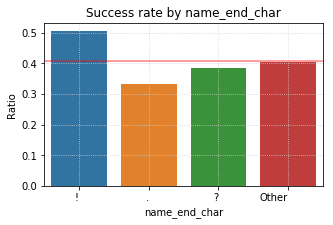

→「！」で終わらすのがよさそう。

▼ name_char_lengthの分布 ※歪度：0.11335226575081644


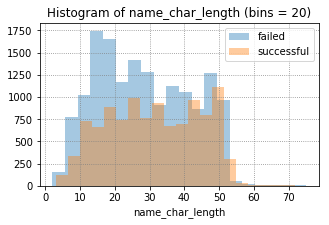

→文字数が少ないと失敗しやすいように見える。

▼ name_char_length別の成功数と失敗数


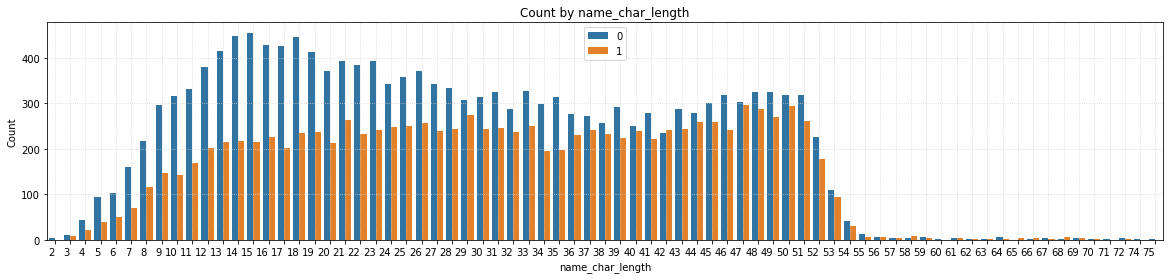


▼ name_char_length別の成功率 ※赤線：学習データの平均成功率


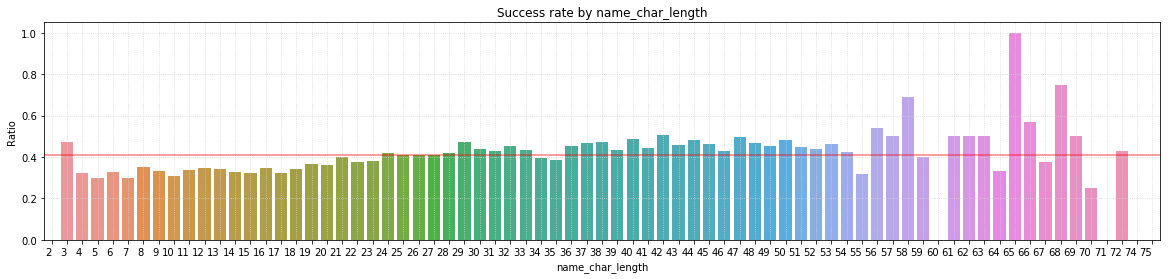

→若干は、成功しやすさの要因になると考えられる。

▼ name_word_numの分布 ※歪度：0.32235348971719036


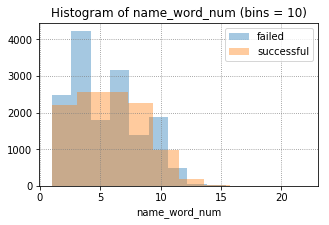


▼ name_word_num別の成功数と失敗数


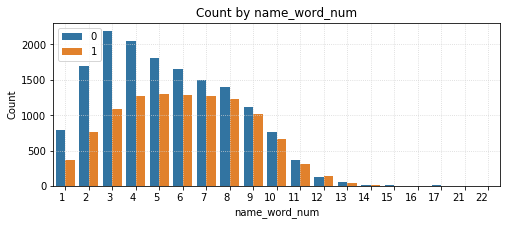


▼ name_word_num別の成功率 ※赤線：学習データの平均成功率


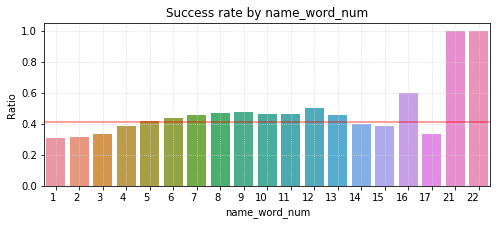

In [11]:
#print(df.name_end_char.value_counts())
df.name_end_char = np.where((df.name_end_char!='!') & (df.name_end_char!='?') & (df.name_end_char!='.'),
                            'Other',df.name_end_char)

print('\n▼ 最終文字の種類')
print(df.name_end_char.value_counts())
print('→nameの最終文字を「!」と「?」と「.」とそれ以外「Other」に分割して比較する。')
show_state_count_plot('name_end_char',5,3)
show_successrate_barplot('name_end_char',5,3,baseline)
print('→「！」で終わらすのがよさそう。')

show_histogram('name_char_length',5,3,20)
print('→文字数が少ないと失敗しやすいように見える。')
show_state_count_plot('name_char_length',20,4)
show_successrate_barplot('name_char_length',20,4,baseline)
print('→若干は、成功しやすさの要因になると考えられる。')

show_histogram('name_word_num',5,3,10)
show_state_count_plot('name_word_num',8,3)
show_successrate_barplot('name_word_num',8,3,baseline)


## 2-4. 無相関化（name_word_numとname_char_length）


▼ name_word_num と name_char_length の相関 ※相関係数: 0.878


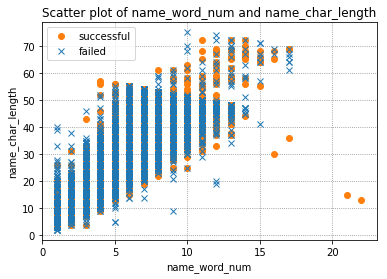

→無相関化しない


In [12]:
# 相関関係の散布図
show_corr_scatter_plot('name_word_num','name_char_length',6,4)

if(decorr_flg):
    # 無相関化する場合
    print('→無相関化してみる')
    f_write('│無相関化する')
    cov_data = df[['name_word_num','name_char_length']].values
    cov = np.cov(cov_data, rowvar=0)            # 分散・共分散を求める
    _, S = np.linalg.eig(cov)                   # 分散共分散行列の固有ベクトルを用いて
    cov_data_decorr = np.dot(S.T, cov_data.T).T # データを無相関化

    df['name_word_num'] = cov_data_decorr[:,0]
    df['name_char_length'] = cov_data_decorr[:,1]

    # 無相関化後の散布図
    show_corr_scatter_plot('name_word_num','name_char_length',6,4)
else:
    # 無相関化しない場合
    print('→無相関化しない')
    f_write('│無相関化しない')

## 2-5.目的変数と説明変数の関係


▼ stateと説明変数（数値項目）の相関関係を確認


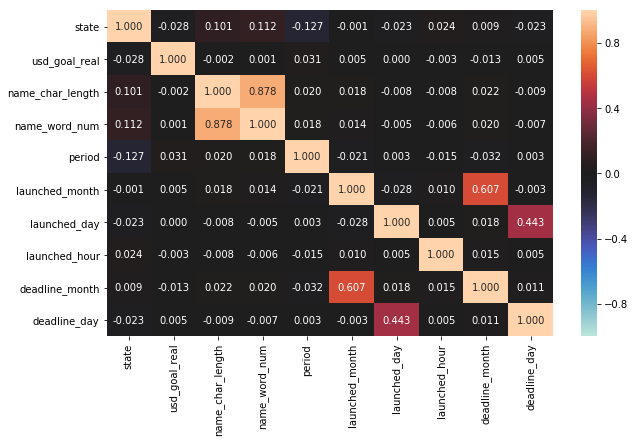

→stateと強い相関があるものはなさそう。


In [13]:
print('\n▼ stateと説明変数（数値項目）の相関関係を確認')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.show()
print('→stateと強い相関があるものはなさそう。')

# 3.データ前処理<a id='prepearing'></a>
## 3-1.データ絞込と説明変数の組み合わせを制御

In [14]:
# データ絞り込む為、念のためシャッフル
tmp_df = df.iloc[np.random.RandomState(seed=1234).permutation(len(df))]

# 計算時間を考慮してデータ絞込
if squeeze_num > 0:
    tmp_df = tmp_df[0:squeeze_num]
    
# 標準化＆白色化する項目リスト
enc_norm_col = ['usd_goal_real','name_word_num','name_char_length']

# カテゴリ項目組み合わせ制御（除外するしない、ダミー変換するしない)
enc_dic = {'main_category':[0,1],
           'category':[0,1],
           'country':[0,1],
           'currency':[0,1],
           'launched_month':[0,1],
           'deadline_month':[0,1],
           'launched_day':[0,1],
           'deadline_day':[0,1],
           'launched_hour':[0,1],
           'period':[0,1],
           'name_end_char':[0,1],
          }

# カテゴリ項目リスト生成
list_one_hot_cols = []
for k, v in enc_dic.items():
    if(v[0]==1): # drop
        tmp_df = tmp_df.drop(k,axis=1)
        print(k + ' is dropped. ')
        f_write('│' + k + ' を説明変数から除外')
    else:
        if(v[1]==1): # one-hot-encoding
            list_one_hot_cols.append(k)
    
print('\n▼ 行列')
print('tmp_df=',tmp_df.shape)

print('\n▼ 先頭3行表示')
display(tmp_df.head(3))


▼ 行列
tmp_df= (20000, 15)

▼ 先頭3行表示


,category,main_category,currency,state,country,usd_goal_real,name_char_length,name_word_num,name_end_char,period,launched_month,launched_day,launched_hour,deadline_month,deadline_day
18444,Shorts,Film & Video,EUR,1,ES,1635.61,12,2,Other,23,10,14,17,11,7
15800,Immersive,Theater,USD,1,US,3600.00,37,7,!,29,6,3,6,7,3
17281,Food Trucks,Food,CAD,0,CA,83161.56,45,8,Other,59,11,30,15,1,29


## 3-2. データ分割（[ホールドアウト法](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)）

In [15]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(tmp_df.drop('state', axis=1), tmp_df['state'],
                                                                test_size=0.3, random_state=1234)

print('\n▼ データ分割後行列')
print('X_train_df=',X_train_df.shape)
print('y_train_df=',y_train_df.shape)
print('X_test_df=',X_test_df.shape)
print('y_test_df=',y_test_df.shape)

print('\n▼ 先頭3行表示')
display(tmp_df.head(3))


▼ データ分割後行列
X_train_df= (14000, 14)
y_train_df= (14000,)
X_test_df= (6000, 14)
y_test_df= (6000,)

▼ 先頭3行表示


,category,main_category,currency,state,country,usd_goal_real,name_char_length,name_word_num,name_end_char,period,launched_month,launched_day,launched_hour,deadline_month,deadline_day
18444,Shorts,Film & Video,EUR,1,ES,1635.61,12,2,Other,23,10,14,17,11,7
15800,Immersive,Theater,USD,1,US,3600.00,37,7,!,29,6,3,6,7,3
17281,Food Trucks,Food,CAD,0,CA,83161.56,45,8,Other,59,11,30,15,1,29


## 3-3. [カテゴリ変換](https://contrib.scikit-learn.org/categorical-encoding/onehot.html)

In [16]:
# one-hot-encoding
ce_ohe = ce.OneHotEncoder(cols=list_one_hot_cols, use_cat_names=True)
enc_X_train_df = ce_ohe.fit_transform(X_train_df)
enc_X_test_df = ce_ohe.transform(X_test_df)

print('\n▼ カテゴリ変換後行列')
print('enc_X_train_df=',enc_X_train_df.shape)
print('enc_X_test_df=',enc_X_test_df.shape)

print('\n▼ カテゴリ変換後')
display(enc_X_train_df.head(5))


▼ カテゴリ変換後行列
enc_X_train_df= (14000, 413)
enc_X_test_df= (6000, 413)

▼ カテゴリ変換後


,category_Country & Folk,category_Crafts,category_Product Design,category_Kids,category_Documentary,category_Music,category_Indie Rock,category_Video Games,category_Fiction,category_Small Batch,category_Periodicals,category_Mobile Games,category_Pop,category_Web,category_Fashion,category_Classical Music,category_Photobooks,category_Translations,category_Television,category_Food,category_Film & Video,category_Nonfiction,category_Architecture,category_Musical,category_3D Printing,category_Immersive,category_Children's Books,category_Rock,category_Games,category_Theater,category_Tabletop Games,category_Drama,category_Shorts,category_Video,category_Photography,category_Wearables,category_Hip-Hop,category_Narrative Film,category_Art,category_Ready-to-wear,category_Accessories,category_Animation,category_Photo,category_Publishing,category_Technology,category_Webseries,category_Metal,category_Nature,category_Comedy,category_Couture,category_Comics,category_Painting,category_World Music,category_People,category_Radio & Podcasts,category_DIY,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Drinks,category_Jazz,category_Apparel,category_Horror,category_Apps,category_Art Books,category_Blues,category_Academic,category_Gaming Hardware,category_Performances,category_Live Games,category_Design,category_Space Exploration,category_Restaurants,category_Science Fiction,category_Sculpture,category_Camera Equipment,category_DIY Electronics,category_Zines,category_Family,category_Romance,category_Electronic Music,category_Literary Journals,category_Software,category_Events,category_Music Videos,category_Farmer's Markets,category_Print,category_Mixed Media,category_Public Art,category_Places,category_Dance,category_Digital Art,category_Poetry,category_Thrillers,category_Plays,category_Performance Art,category_Anthologies,category_Latin,category_Gadgets,category_Video Art,category_Festivals,category_Playing Cards,category_Comic Books,category_Animals,category_Faith,category_Illustration,category_Journalism,category_Action,category_Food Trucks,category_Robots,category_Jewelry,category_Printing,category_Puzzles,category_Farms,category_Footwear,category_Woodworking,category_Crochet,category_Experimental,category_Fantasy,category_Webcomics,category_Conceptual Art,category_Installations,category_Interactive Design,category_Childrenswear,category_Pet Fashion,category_Sound,category_Cookbooks,category_Candles,category_Calendars,category_R&B,category_Workshops,category_Community Gardens,category_Vegan,category_Audio,category_Spaces,category_Punk,category_Pottery,category_Movie Theaters,category_Young Adult,category_Flight,category_Knitting,category_Fine Art,category_Ceramics,category_Civic Design,category_Letterpress,category_Makerspaces,category_Taxidermy,category_Stationery,category_Fabrication Tools,category_Glass,category_Bacon,category_Residencies,category_Weaving,category_Chiptune,category_Textiles,category_Embroidery,category_Typography,category_Quilts,main_category_Music,main_category_Crafts,main_category_Design,main_category_Film & Video,main_category_Games,main_category_Publishing,main_category_Food,main_category_Technology,main_category_Fashion,main_category_Photography,main_category_Journalism,main_category_Theater,main_category_Art,main_category_Comics,main_category_Dance,currency_USD,currency_EUR,currency_MXN,currency_GBP,currency_AUD,currency_HKD,currency_CAD,currency_NZD,currency_SEK,currency_DKK,currency_SGD,currency_NOK,currency_CHF,country_US,country_ES,country_MX,country_GB,country_AU,country_HK,country_DE,country_CA,country_FR,country_IT,country_NZ,country_IE,country_SE,country_AT,country_DK,country_NL,country_SG,country_NO,country_BE,country_CH,country_LU,usd_goal_real,name_char_length,name_word_num,name_end_char_Other,name_end_char_!,name_end_char_.,name_end_char_?,period_44.0,period_8.0,period_29.0,period_58.0,period_13.0,period_14.0,period_34.0,period_30.0,period_32.0,period_50.0,period_57.0,period_53.0,per

## 3-4. [標準化](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


▼ndarray変換
X_train.shape= (14000, 413)
X_test.shape= (6000, 413)

▼標準化対象列
{'usd_goal_real': 207, 'name_word_num': 209, 'name_char_length': 208}

▼標準化


<Figure size 432x288 with 0 Axes>

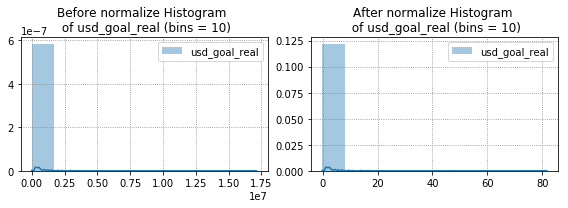

<Figure size 432x288 with 0 Axes>

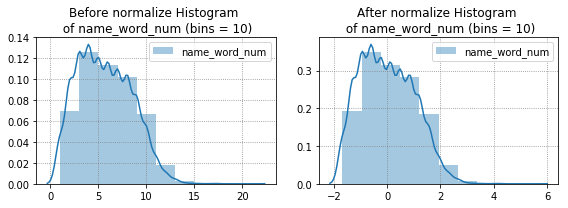

<Figure size 432x288 with 0 Axes>

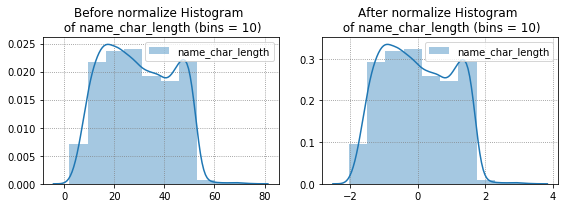

In [17]:
# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, enc_X_train_df.columns.get_loc(col_name))
    dic_norm_col.setdefault(col_name, X_train_df.columns.get_loc(col_name))
X_columns = enc_X_train_df.columns
list_X_columns = X_columns.tolist()

# ndarrayに変換
X_train = enc_X_train_df.values
y_train = y_train_df.values
X_test = enc_X_test_df.values
y_test = y_test_df.values

print('\n▼ndarray変換')
print('X_train.shape=',X_train.shape)
print('X_test.shape=',X_test.shape)

print('\n▼標準化対象列')
print(dic_norm_col)

print('\n▼標準化')
for col_name,col_idx in dic_norm_col.items():
    
    plt.subplots_adjust(wspace=8.0, hspace=2.0) # 余白
    plt.figure(figsize=(8,3))
    
    # 標準化前
    plt.subplot(1,2,1)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('Before normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    
    # 標準化
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    
    #　標準化後
    plt.subplot(1,2,2)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('After normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.tight_layout() # 重ならないように
    plt.show()
    

# 4.特徴選択<a id='selection'></a>
## 4-1. ステップワイズ法

In [18]:
if(wrapper_flg):
    print('→ラッパー法（ステップワイズ法）する')
    f_write('│ラッパー法（ステップワイズ法）する')
    
    # RFECVは交差検証によってステップワイズ法による特徴選択を行う
    kfold = KFold(n_splits=10, random_state=1234)
    #estimator = RandomForestClassifier(n_estimators=10,max_depth=2,criterion="gini",min_samples_leaf=2,min_samples_split=2, random_state=1234)
    estimator = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
    rfecv = RFECV(estimator, cv=kfold, scoring='accuracy')
    rfecv.fit(X_train, y_train)

    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    print(plt.show())

    remove_feature = X_columns[ ~rfecv.support_]
    for f in remove_feature:
        list_X_columns.remove(f)

    print('\n▼利用対象の特徴数')
    print('len(list_X_columns)=',len(list_X_columns))   

    X_train = X_train[:,rfecv.support_]
    X_test = X_test[:,rfecv.support_]

    print('\n▼ ラッパー法実施後行列')
    print('X_train=',X_train.shape)
    print('X_test=',X_test.shape)
else:
    print('→ラッパー法（ステップワイズ法）しない')
    f_write('│ラッパー法（ステップワイズ法）しない')

→ラッパー法（ステップワイズ法）しない


# 5. モデル構築<a id='modeling'></a>

In [19]:
dic_argo = {} # アルゴリズムごとに結果を格納
kfold = KFold(n_splits=5, random_state=1234)
def grid_search_argo(dic_argo, model_name, clf, param, X_train, y_train):
    
    # グリッドサーチ
    grid = GridSearchCV(estimator=clf, param_grid=param, scoring='accuracy', cv=kfold, n_jobs=-1)
    
    # 学習
    grid_result = grid.fit(X_train, y_train)

    best_estimator = grid_result.best_estimator_
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    #for mean, stdev, param in zip(means, stds, params):
    #    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    #    print("----------------------------------------------")
    
    print("★BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    dic_argo.setdefault(model_name, grid_result) # 辞書に格納
    
    return best_estimator

## 5-1. パラメーターチューニング（単体アルゴリズム）

### 5-1-1. [ロジスティック回帰](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [20]:
lr_clf = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
lr_param = {'penalty' : ['none','l1','l2','elasticnet'],#正則化項（default = 'l2'）
                 'alpha' : [1e-4, 1e-3] # 正則化項の効き具合(default = 0.0001:1e-4)
                }
best_lr = grid_search_argo(dic_argo, 'logisticRegression', lr_clf, lr_param, X_train, y_train)

★BestScore: 0.669786 using {'alpha': 0.001, 'penalty': 'elasticnet'}


### 5-1-2. [サポートベクターマシン](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [21]:
'''
svc_clf = SVC()
svc_param_grid = [{'kernel': ['linear'], 'C': [0.1,1]},
                  {'kernel': ['rbf'], 'gamma': [0.1, 1e-2],'C': [0.1,1],'random_state' : [1234]}
                 ]
best_SVM = grid_search_argo(dic_argo, 'SVM', svc_clf, svc_param_grid, X_train, y_train)
'''

"\nsvc_clf = SVC()\nsvc_param_grid = [{'kernel': ['linear'], 'C': [0.1,1]},\n                  {'kernel': ['rbf'], 'gamma': [0.1, 1e-2],'C': [0.1,1],'random_state' : [1234]}\n                 ]\nbest_SVM = grid_search_argo(dic_argo, 'SVM', svc_clf, svc_param_grid, X_train, y_train)\n"

### 5-1-3. 決定木

In [22]:
dt_clf = DecisionTreeClassifier()
dt_param_grid = {'max_depth' : [2,3],'min_samples_split': [2,3],  'min_samples_leaf':[1,3]}
best_dt = grid_search_argo(dic_argo, 'DecisionTree', dt_clf,dt_param_grid,X_train,y_train)

★BestScore: 0.621929 using {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


## 5-2. パラメータチューニング（アンサンブル）
### 5-2-1. ランダムフォレスト

In [23]:
RFC_clf = RandomForestClassifier()
RFC_param = {"max_depth": [None],"min_samples_split": [2,3],"min_samples_leaf": [3,4],
                  "n_estimators" :[100],"criterion": ["gini"]}
best_RFC = grid_search_argo(dic_argo, 'RandomForest', RFC_clf, RFC_param, X_train, y_train)

★BestScore: 0.681143 using {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


### 5-2-2. アダブースト

In [24]:
ABC_clf = AdaBoostClassifier(DecisionTreeClassifier(), random_state=1234)
ABC_param = {"base_estimator__criterion" : ["gini"],
             "base_estimator__max_depth" : [2,None],
             "base_estimator__min_samples_split" : [2], "base_estimator__min_samples_leaf" : [3],"n_estimators" :[100]}
best_ABC = grid_search_argo(dic_argo, 'AdaBoost', ABC_clf, ABC_param, X_train, y_train)

★BestScore: 0.664857 using {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 2, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 2, 'n_estimators': 100}


### 5-2-3. GradiantBoosting

In [25]:
GBC_clf = GradientBoostingClassifier()
GBC_param = {'loss' : ["deviance"],'n_estimators' : [100],
                  'max_depth': [3],'min_samples_leaf': [1],'min_samples_split': [2]}
best_GBC = grid_search_argo(dic_argo, 'GradientBoosting', GBC_clf, GBC_param, X_train, y_train)

★BestScore: 0.678714 using {'loss': 'deviance', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### 5-2-4. XGBoost

In [26]:
XGB_clf = xgb.XGBClassifier()
XGB_param = {'nthread':[4], 'objective':['binary:logistic'],'learning_rate': [0.001],'max_depth': [2],'min_child_weight': [0],
              'silent': [1],'subsample': [0.8],'colsample_bytree': [0.7],'n_estimators': [100],'missing':[-999],'seed': [1234]}
best_XGB = grid_search_argo(dic_argo, 'XGBoost', XGB_clf, XGB_param, X_train, y_train)

★BestScore: 0.628714 using {'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 2, 'min_child_weight': 0, 'missing': -999, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1234, 'silent': 1, 'subsample': 0.8}


### 5-3. パラメータチューニング（ニューラルネットワーク）
#### 5-3-1. [ ニューラルネットワーク](https://keras.io/ja/layers/core/)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

▼ Day3 モデルの評価結果
正答率（訓練データ） = 78.257%
正答率（テストデータ）= 62.433% ※汎化性能


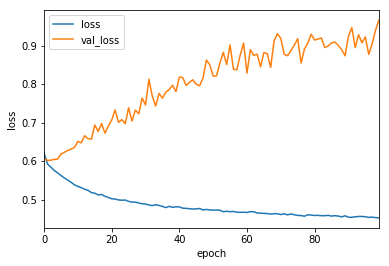

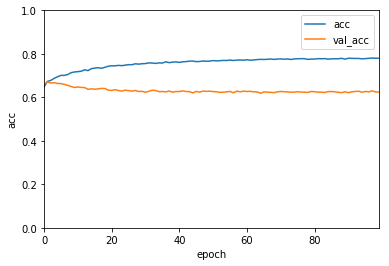

In [27]:
from keras.wrappers.scikit_learn import KerasClassifier
use_multiprocessing=False

nn_mdl = Sequential()
nn_mdl.add(Dense(units=6, activation='relu', input_dim=len(list_X_columns)))
nn_mdl.add(Dense(units=10, activation='relu')) 
nn_mdl.add(Dense(units=1, activation='sigmoid'))
nn_mdl.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

# 学習
fit = nn_mdl.fit(X_train, y_train, epochs=100, batch_size=30, validation_data=(X_test, y_test),verbose=0) 

# 予測
y_train_pred_NN =(nn_mdl.predict(X_train) > 0.5).reshape(-1,)
y_test_pred_NN =(nn_mdl.predict(X_test) > 0.5).reshape(-1,)

# 正答率
score_train = 100 * accuracy_score(y_train, y_train_pred_NN)
score_test = 100 * accuracy_score(y_test, y_test_pred_NN)

print('\n▼ Day3 モデルの評価結果')
print('正答率（訓練データ） = {:.3f}%'.format(score_train))
print('正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))


# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()


## 6. モデルの検証

In [28]:
# 最良スコアのモデルを取得
first_flg = True
f_write('│▽検証したアルゴリズム数：' + str(len(dic_argo)))
print('検証したアルゴリズム数：',len(dic_argo))
for k,grid_result in dic_argo.items():
    tmp_score = grid_result.best_score_
    f_write('│' + str(k) + ' :  {:.3f}%'.format(tmp_score * 100))
    if (first_flg):
        max_score = tmp_score
        best_model = k
        best_clf = grid_result.best_estimator_
        best_param = grid_result.best_params_
        first_flg = False
    if (max_score < tmp_score):
        max_score = tmp_score
        best_model = k
        best_clf = grid_result.best_estimator_
        best_param = grid_result.best_params_

print('\n▼ BestModel')
print(str(best_model) + '：' + str(best_param))

# 学習
best_clf.fit(X_train, y_train)

# 予測
y_train_pred = best_clf.predict(X_train) # 訓練データ
y_test_pred = best_clf.predict(X_test) # テストデータ

# 正答率
score_train = 100 * accuracy_score(y_train, y_train_pred)
score_test = 100 * accuracy_score(y_test, y_test_pred)

# Precision, Recall, F1-score計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
v_precision = 100 * precision[0]
v_recall= 100 * recall[0]
v_F1 = 100 * f1_score[0]

print('\n▼ Day3 モデルの評価結果')
print('最良モデル = ' + str(best_model) + '：' + str(best_param))
print('データ数（test_size=0.3） = ' + str(len(tmp_df)))
print('説明変数の数（one-hot前） = ' + str(len(X_train_df.columns)))
print('正答率（訓練データ） = {:.3f}%'.format(score_train))
print('正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))

検証したアルゴリズム数： 6

▼ BestModel
RandomForest：{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

▼ Day3 モデルの評価結果
最良モデル = RandomForest：{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
データ数（test_size=0.3） = 20000
説明変数の数（one-hot前） = 14
正答率（訓練データ） = 83.893%
正答率（テストデータ）= 66.800% ※汎化性能


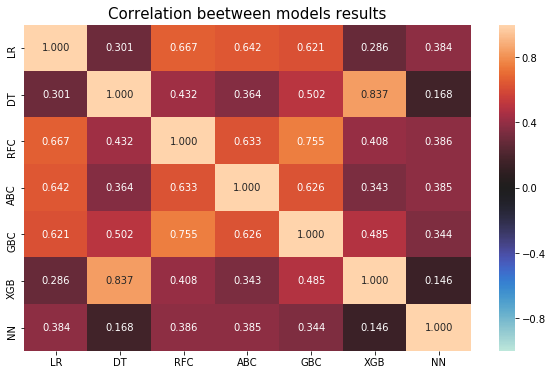

In [29]:
# 予測結果をヒートマップで比較
ensemble_results = pd.concat([pd.Series(best_lr.predict(X_test), name="LR"), 
                              pd.Series(best_dt.predict(X_test), name="DT"), 
                              #pd.Series(best_SVM.predict(X_test), name="SVM"), 
                              pd.Series(best_RFC.predict(X_test), name="RFC"),
                              pd.Series(best_ABC.predict(X_test), name="ABC"),
                              pd.Series(best_GBC.predict(X_test), name="GBC"),
                              pd.Series(best_XGB.predict(X_test), name="XGB"),
                              pd.Series(y_test_pred_NN, name="NN"),
                             ],axis=1)

plt.figure(figsize =(10, 6))
sns.heatmap(ensemble_results.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.title('Correlation beetween models results', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [30]:
# コンセプトの異なる機械学習分類器を組み合わせ、多数決や予測の平均(弱い投票)を使用し、クラスラベルを予測する
votingC = VotingClassifier(estimators=[('lr', best_lr),
                                       #('dt', best_dt),
                                       #('svm', best_SVM),
                                       ('abc', best_ABC),
                                       ('rfc', best_RFC),
                                       ('gbc', best_GBC),
                                       #('xgb', best_XGB)
                                      ], 
                           voting='hard', n_jobs=-1)
# 学習
votingC = votingC.fit(X_train, y_train)

# 予測
y_train_pred = votingC.predict(X_train) # 訓練データ
y_test_pred = votingC.predict(X_test) # テストデータ

# 正答率
score_train = 100 * accuracy_score(y_train, y_train_pred)
score_test = 100 * accuracy_score(y_test, y_test_pred)

# Precision, Recall, F1-score計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
v_precision = 100 * precision[0]
v_recall= 100 * recall[0]
v_F1 = 100 * f1_score[0]

print('\n▼ Day3 モデルの評価結果')
print('最良モデル = ' + str(best_model) + '：' + str(best_param))
print('データ数（test_size=0.3） = ' + str(len(tmp_df)))
print('説明変数の数（one-hot前） = ' + str(len(X_train_df.columns)))
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
print('正答率（訓練データ） = {:.3f}%'.format(score_train))
print('正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))


▼ Day3 モデルの評価結果
最良モデル = RandomForest：{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
データ数（test_size=0.3） = 20000
説明変数の数（one-hot前） = 14
対数尤度 = -11.398
正答率（訓練データ） = 74.643%
正答率（テストデータ）= 67.000% ※汎化性能


# 4.モデル評価

In [31]:
# 予測
y_train_pred = votingC.predict(X_train) # 訓練データ
y_test_pred = votingC.predict(X_test) # テストデータ

# 正答率
score_train = 100 * accuracy_score(y_train, y_train_pred)
score_test = 100 * accuracy_score(y_test, y_test_pred)

# Precision, Recall, F1-score計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
v_precision = 100 * precision[0]
v_recall= 100 * recall[0]
v_F1 = 100 * f1_score[0]

print('\n▼ Day3 モデルの評価結果')
print('最良モデル = ' + str(best_model) + '：' + str(best_param))
print('データ数（test_size=0.3） = ' + str(len(tmp_df)))
print('説明変数の数（one-hot前） = ' + str(len(X_train_df.columns)))
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
print('正答率（訓練データ） = {:.3f}%'.format(score_train))
print('正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))
print('適合率（Precision※精度) = {:.3f}%'.format(v_precision))
print('再現率（Recall※検出率) = {:.3f}%'.format(v_recall))
print('F1値（F1-score） = {:.3f}%'.format(v_F1))
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])
display(conf_mat)

# 計算時間
proc_time = time() - start_notebook
print('計算時間（分）：{:.2f}'.format(proc_time / 60)) 

# 結果をファイル出力
f_write('│▽最良モデル')
f_write('│' + str(best_model) + '：' + str(best_param))
f_write('│▽使用データ')
f_write('│データ数（test_size=0.3） = ' + str(len(tmp_df)))
f_write('│説明変数の数（one-hot前） = ' + str(len(X_train_df.columns)))
f_write('│▽評価結果')
f_write('│対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
f_write('│正答率（訓練データ） = {:.3f}%'.format(score_train))
f_write('│正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))
f_write('│適合率（Precision※精度) = {:.3f}%'.format(v_precision))
f_write('│再現率（Recall※検出率) = {:.3f}%'.format(v_recall))
f_write('│F1値（F1-score） = {:.3f}%'.format(v_F1))
f_write('│計算時間（分）：{:.2f}'.format(proc_time / 60)) 
f_write('▲処理終了')


▼ Day3 モデルの評価結果
最良モデル = RandomForest：{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
データ数（test_size=0.3） = 20000
説明変数の数（one-hot前） = 14
対数尤度 = -11.398
正答率（訓練データ） = 74.643%
正答率（テストデータ）= 67.000% ※汎化性能
適合率（Precision※精度) = 67.801%
再現率（Recall※検出率) = 84.522%
F1値（F1-score） = 75.244%

▼ 混同行列


,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,3009,551
正解 = 資金調達成功,1429,1011


計算時間（分）：5.99


### ◆気になること
- 少ない件数にてロジスティック回帰もSVMも汎化性能がほぼ同じなので、計算の遅いSVMは対象外にしてもよいかもしれない。
- 学習曲線用の関数を使ってプロットしてみました。y軸が上がbadで下がgoodではなかったですが、これでもよいでしょうか。
- 対数変換は学習時にも有効と教えて頂きましたが、分布に偏りのある目標金額を対数変換して説明変数とすることは有効なのでしょうか。

### ────────────────────────────────────────────────────────────────
### ◆これまでの記録

#### Day1 モデルの評価結果（標準化なし）
- ロジスティック回帰モデル（正則化項なし）
- 対数尤度 = -14.931
- 正答率（訓練データ) = 56.772%
- 適合率（Precision※精度) = 73.061%
- 再現率（Recall※検出率) = 43.540%
- F1値（F1-score） = 54.563%

####  Day2 モデルの評価結果
- 最良モデル = LogisticRegression：{'alpha': 0.0001, 'penalty': 'l1'}
- データ数（test_size=0.3） = 11000
- 説明変数の数（one-hot前） = 14
- 対数尤度 = -11.314
- 正答率（訓練データ） = 69.286%
- 正答率（テストデータ）= 67.242% ※汎化性能
- 適合率（Precision※精度) = 71.598%
- 再現率（Recall※検出率) = 74.195%
- F1値（F1-score） = 72.873%